In [18]:
#Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Wedge
from matplotlib.collections import PatchCollection
import plotly.express as px
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np
np.float = float
import warnings
import yfinance as yf
import math
from numpy import linalg as LA
warnings.filterwarnings("ignore")

In [3]:
#Importing XLF historical data
xlf = pd.read_csv('XLF_HISTDATA.csv')

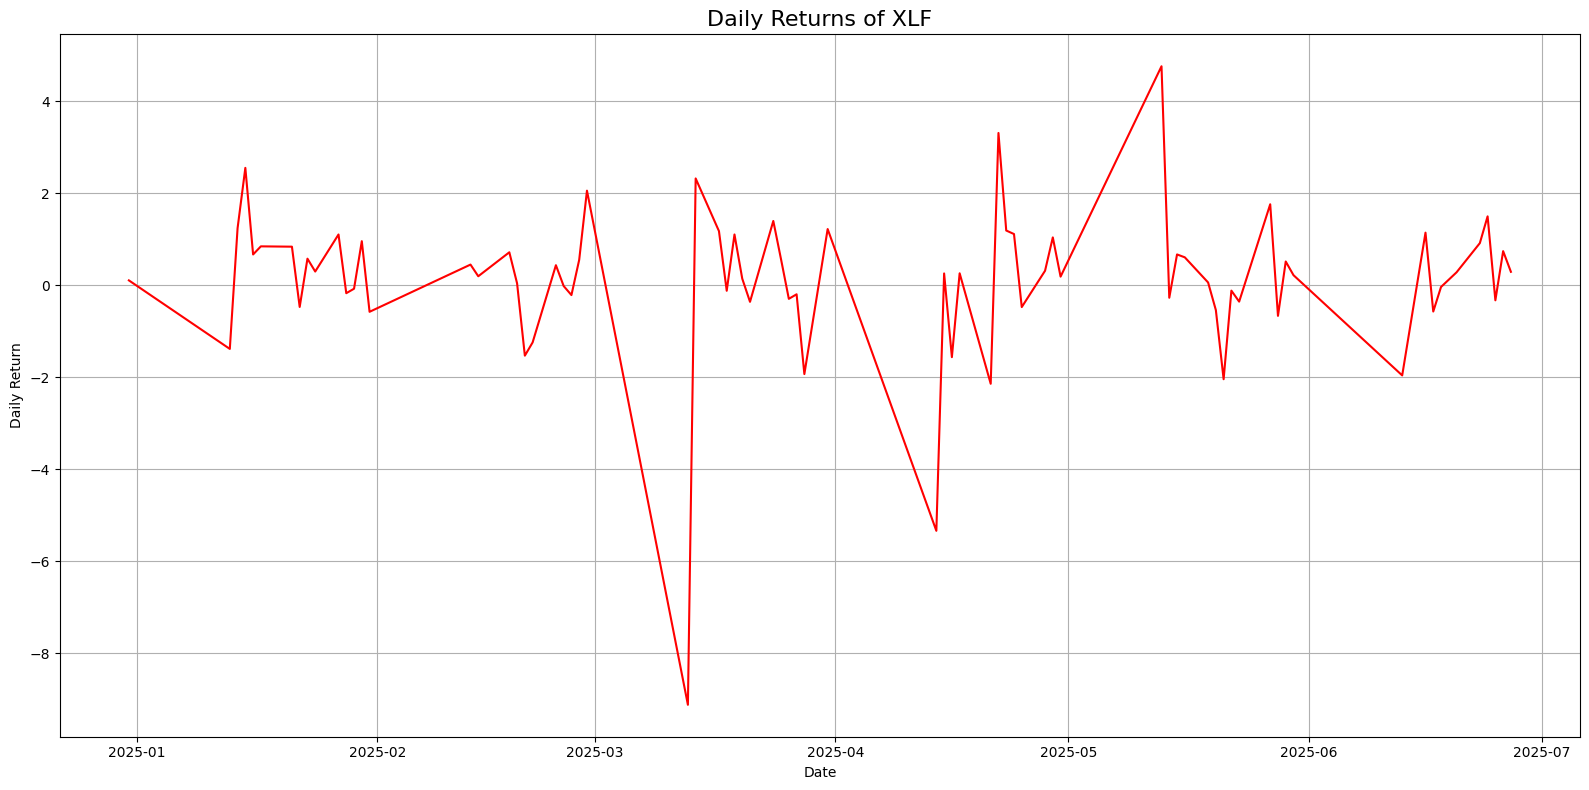

In [8]:
#Calculating daily returns for XLF
xlf['Date'] = xlf['Date'].astype(str).str.strip()
xlf['Date'] = pd.to_datetime(xlf['Date'], dayfirst=True, errors='coerce')
xlf['Date'] = pd.to_datetime(xlf['Date'], format='%d-%m-%Y')
xlf.dropna(subset=['Date'], inplace=True)
xlf = xlf.sort_values('Date')
xlf['daily_return'] = xlf['Close/Last'].pct_change() *100
plt.figure(figsize=(16, 8))
plt.plot(xlf['Date'], xlf['daily_return'], label='XLF Daily Returns', color='red')
plt.title('Daily Returns of XLF', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
#Fetching top 30 holdings data for XLF
top_30 = [ 'BRK-B', 'JPM', 'V', 'MA', 'BAC', 'WFC', 'GS', 'AXP', 'MS', 'SPGI', 'C', 'SCHW', 'BLK', 'PGR', 'COF', 'BX', 'MMC', 'CB', 'ICE', 'CME', 'FI', 'KKR', 'AJG', 'PNC', 'MCO', 'AON', 'COIN', 'PYPL', 'USB', 'BK']
start_date = xlf['Date'].min().date()
end_date = xlf['Date'].max().date()
price_data = yf.download(top_30, start=start_date, end=end_date, auto_adjust = False)['Adj Close']

[*********************100%***********************]  30 of 30 completed


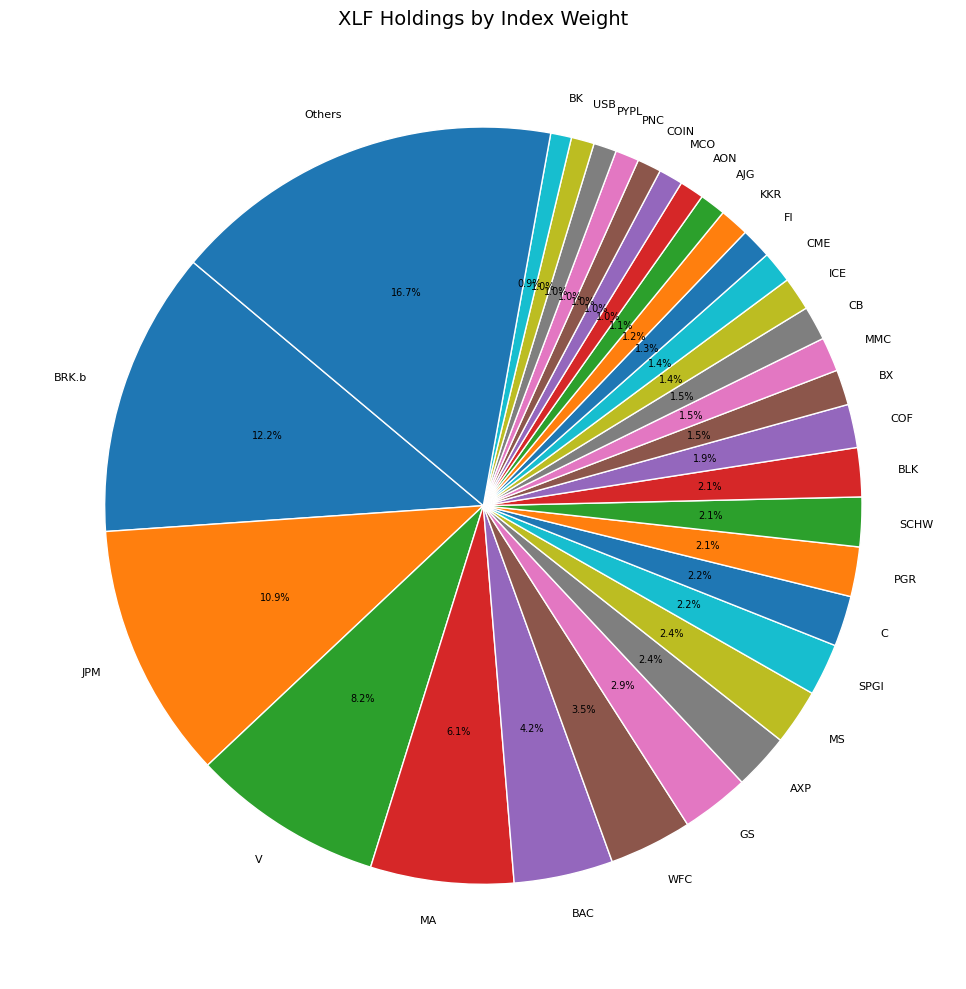

In [20]:
T30_holdings = pd.read_csv('XLF_HOLDINGS.csv')

T30_holdings['Index Weight'] = T30_holdings['Index Weight'].str.replace('%', '', regex=False).astype(float)
top30 = T30_holdings.sort_values(by='Index Weight', ascending=False).head(30).copy()
others_weight = 100 - top30['Index Weight'].sum()
others_row = pd.DataFrame([{'Symbol': 'Others', 'Index Weight': others_weight}])
top30 = pd.concat([top30, others_row], ignore_index=True)

plt.figure(figsize=(10, 10))
patches, texts, autotexts = plt.pie(
    top30['Index Weight'],
    labels=top30['Symbol'],
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops=dict(edgecolor='w')
)


for text in texts:
    text.set_fontsize(8)
for autotext in autotexts:
    autotext.set_fontsize(7)

plt.title('XLF Holdings by Index Weight', fontsize=14)
plt.tight_layout()
plt.show()

In [7]:
#Calculating daily returns for top 30 holdings
price_returns = price_data.pct_change().dropna()
price_returns.head()

Ticker,AJG,AON,AXP,BAC,BK,BLK,BRK-B,BX,C,CB,...,MMC,MS,PGR,PNC,PYPL,SCHW,SPGI,USB,V,WFC
Date,,,,,,,,,,,,,,,,,,,,,
2024-12-31,-0.002144,0.003324,-0.001816,0.000911,-0.003631,-0.002258,0.002477,0.002151,0.000000,0.003231,...,0.002029,-0.000239,0.000042,0.001662,-0.000936,0.001082,0.000020,0.001675,0.002315,-0.002415
2025-01-02,-0.028043,-0.011638,0.005526,0.007736,0.007549,-0.007521,-0.004809,0.007714,-0.006393,-0.013681,...,-0.005037,-0.007477,0.004340,-0.007571,0.009725,-0.002297,-0.005080,0.000627,-0.005189,-0.000712
2025-01-03,0.016347,-0.002817,0.017969,0.011741,-0.006201,0.003371,0.005453,0.012432,0.015156,-0.002899,...,-0.000331,0.009296,0.006524,0.022154,0.016477,0.008261,0.008214,0.020894,0.001622,0.015957
2025-01-06,-0.014194,-0.015566,-0.003959,0.013167,0.012869,-0.007925,-0.004740,-0.006367,0.024507,-0.016266,...,-0.013206,0.021439,-0.010858,-0.000204,0.022032,0.000403,-0.010769,-0.002661,-0.005938,0.010097
2025-01-07,0.012119,-0.000086,0.000464,0.014978,0.000513,-0.031578,0.003345,-0.019738,0.012923,0.005424,...,0.007195,-0.013682,0.011228,-0.004192,-0.017424,-0.029807,-0.005747,-0.000616,-0.004376,-0.006109


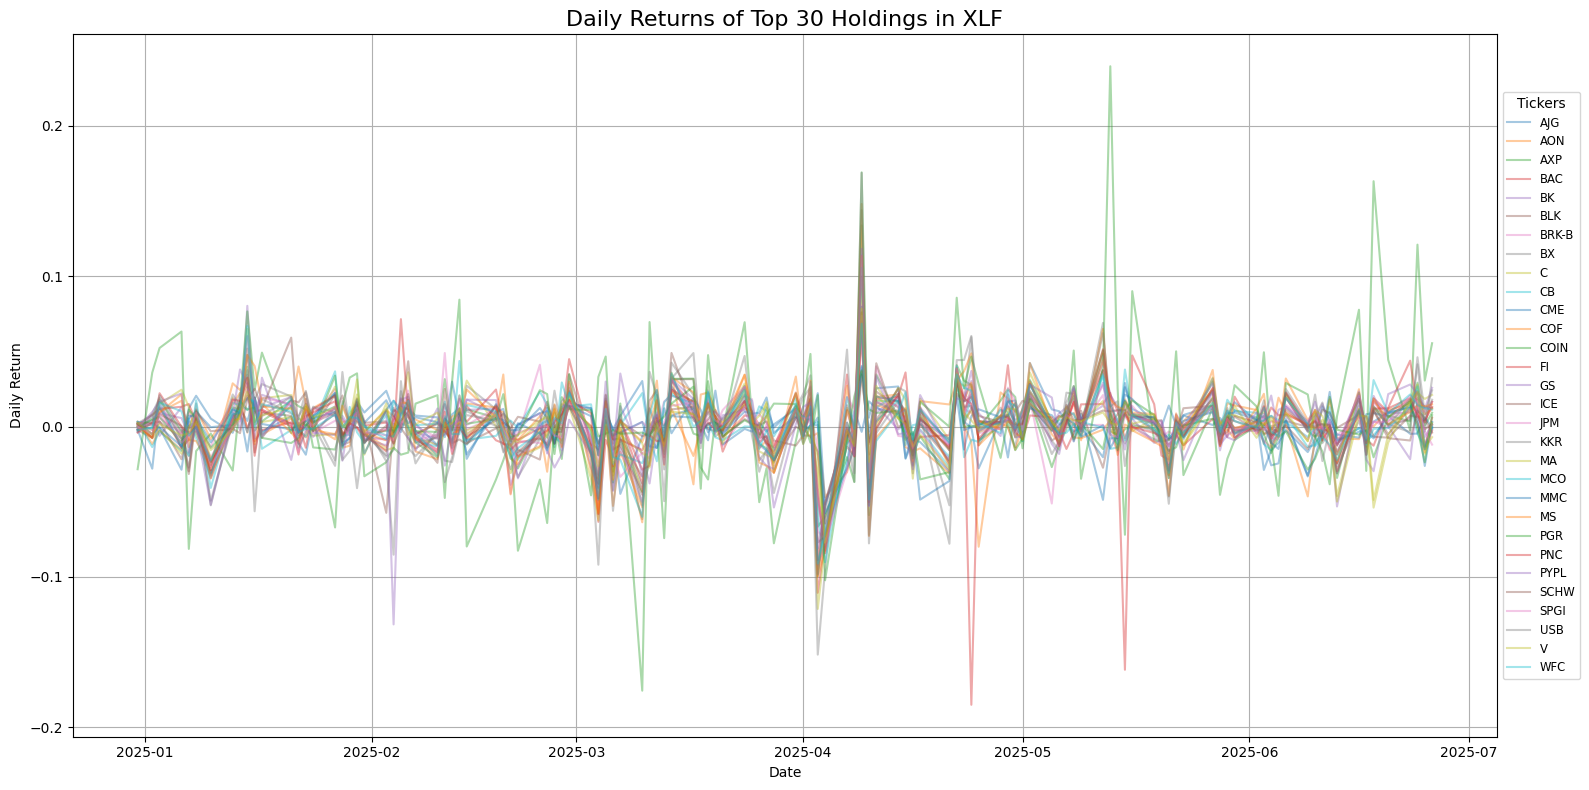

In [ ]:
 #Plotting daily returns for top 30 holdings
plt.figure(figsize=(16, 8))

for ticker in price_returns.columns:
    plt.plot(price_returns.index, price_returns[ticker], alpha=0.4, label=ticker)

plt.title('Daily Returns of Top 30 Holdings in XLF', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Tickers', fontsize='small', ncol=1)
plt.tight_layout()
plt.show()

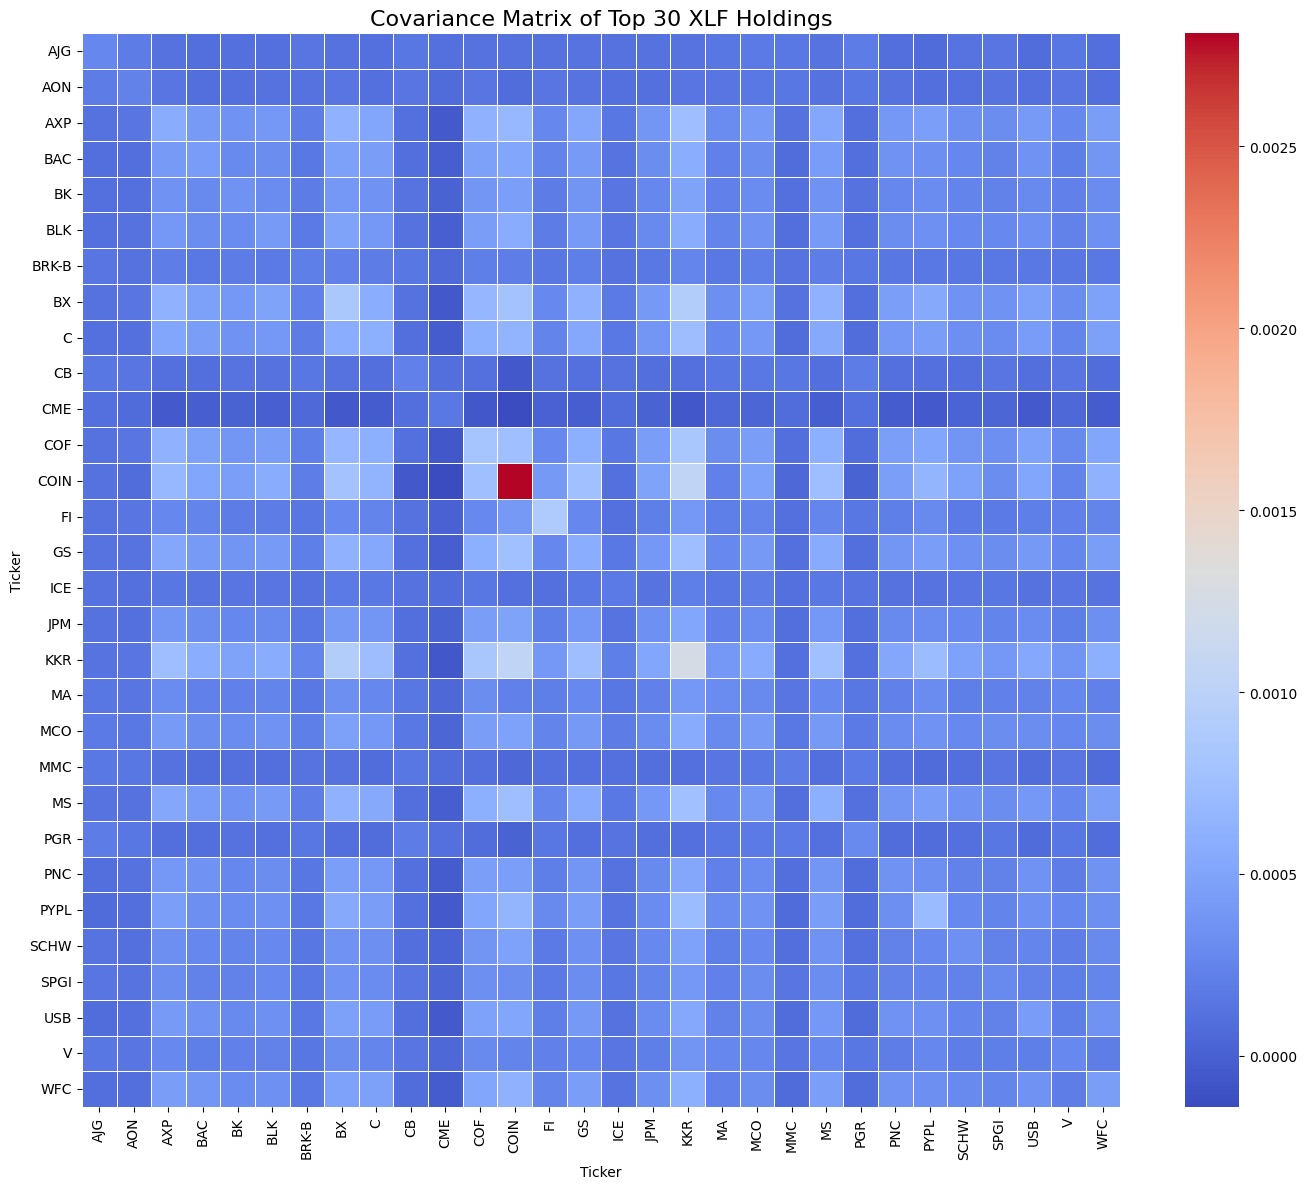

In [ ]:
#Creating covariance matrix for top 30 holdings of XLF
price_cov = price_returns.cov()

plt.figure(figsize=(14, 12))
sns.heatmap(price_cov, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)

plt.title('Covariance Matrix of Top 30 XLF Holdings', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
#PCA
pca = PCA()
pca.fit(price_returns)
explained_variance = pca.explained_variance_ratio_
components = pca.components_

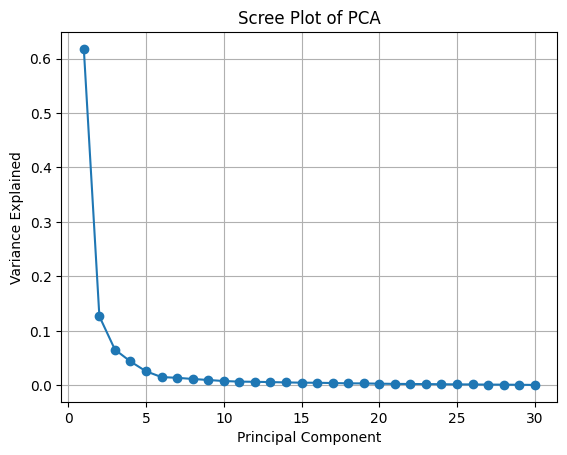

In [ ]:
#Plotting scree plot for PCA
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
plt.title('Scree Plot of PCA')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.grid(True)
plt.show()

In [ ]:
#SVD
U, S, Vt = np.linalg.svd(price_returns - price_returns.mean(), full_matrices=False)
normalized_S = S / np.sum(S)

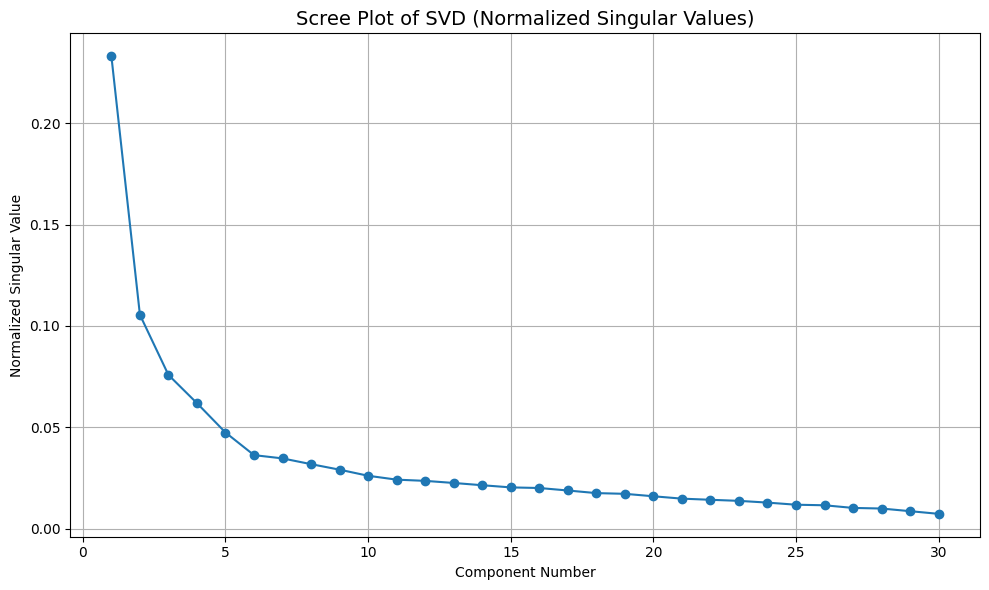

In [ ]:
#Plotting scree plot for SVD
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(S) + 1), normalized_S, marker='o')
plt.title('Scree Plot of SVD (Normalized Singular Values)', fontsize=14)
plt.xlabel('Component Number')
plt.ylabel('Normalized Singular Value')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Present the result
print("Stock Returns Matrix Dimension:")
print(price_returns.shape)
print("\nDimension of Matrix U:")
print(U.shape)
print("\nSingular values:")
print(S)
print("\nDimension of Matrix V^T:")
print(Vt.shape)

Stock Returns Matrix Dimension:
(121, 30)

Dimension of Matrix U:
(121, 30)

Singular values:
[1.08170541 0.48980078 0.35220133 0.28756809 0.22042259 0.16863288
 0.16114165 0.1479717  0.13532614 0.121398   0.11250899 0.1097334
 0.10492212 0.09974676 0.09478719 0.09338691 0.0876868  0.08171216
 0.08006789 0.07446684 0.06903337 0.06643785 0.06396051 0.05997405
 0.05512603 0.05385455 0.04779937 0.04641523 0.04034488 0.0342511 ]

Dimension of Matrix V^T:
(30, 30)


In [ ]:
# Standardize stock returns dataset
stocks_returns_means = price_returns.mean()
stocks_returns_stds = price_returns.std()
standardized_returns = (price_returns - stocks_returns_means) / stocks_returns_stds
standardized_returns.head()

Ticker,AJG,AON,AXP,BAC,BK,BLK,BRK-B,BX,C,CB,...,MMC,MS,PGR,PNC,PYPL,SCHW,SPGI,USB,V,WFC
Date,,,,,,,,,,,,,,,,,,,,,
2024-12-31,-0.196957,0.216666,-0.105640,-0.002360,-0.278168,-0.125920,0.124307,0.097049,-0.079101,0.193524,...,0.126785,-0.062636,-0.057991,0.086556,-0.000435,-0.038870,-0.025349,0.084098,0.082570,-0.179711
2025-01-02,-1.769433,-0.762898,0.201265,0.328318,0.322026,-0.382549,-0.380918,0.287484,-0.342758,-0.952673,...,-0.393537,-0.359133,0.192613,-0.401711,0.401736,-0.222720,-0.324484,0.033417,-0.366551,-0.098619
2025-01-03,0.925759,-0.185395,0.721417,0.522351,-0.416112,0.148576,0.330682,0.448983,0.545960,-0.221949,...,-0.046973,0.327933,0.319921,1.170220,0.656459,0.351686,0.455238,1.013422,0.041092,0.695222
2025-01-06,-0.928572,-1.020031,-0.195228,0.591432,0.607588,-0.402242,-0.376126,-0.194512,0.931633,-1.127896,...,-0.995044,0.825305,-0.693442,-0.012157,0.866004,-0.075818,-0.658174,-0.125567,-0.411379,0.416143
2025-01-07,0.669060,-0.006604,-0.010342,0.679194,-0.055672,-1.555573,0.184501,-0.652220,0.453868,0.342148,...,0.507234,-0.613290,0.594134,-0.223055,-0.622406,-1.719325,-0.363588,-0.026678,-0.317907,-0.355648


In [ ]:
# Calculate covariance for standardized return matrix
standardized_returns_dvd_sqrt_n=(standardized_returns/math.sqrt(len(standardized_returns)-1))
standardized_returns_cov = standardized_returns_dvd_sqrt_n.T@standardized_returns_dvd_sqrt_n
standardized_returns_cov

Ticker,AJG,AON,AXP,BAC,BK,BLK,BRK-B,BX,C,CB,...,MMC,MS,PGR,PNC,PYPL,SCHW,SPGI,USB,V,WFC
Ticker,,,,,,,,,,,,,,,,,,,,,
AJG,1.000000,0.723021,0.313641,0.270733,0.357854,0.328835,0.577929,0.253638,0.275500,0.644920,...,0.752279,0.313541,0.678313,0.312963,0.164918,0.411257,0.514680,0.258590,0.541281,0.286543
AON,0.723021,1.000000,0.390867,0.303424,0.387570,0.365159,0.521523,0.324765,0.290094,0.629501,...,0.730249,0.330351,0.583207,0.394675,0.246717,0.364719,0.504883,0.341286,0.552842,0.290851
AXP,0.313641,0.390867,1.000000,0.836824,0.811250,0.816030,0.562141,0.893362,0.886835,0.301723,...,0.371977,0.895693,0.227477,0.879711,0.713000,0.750548,0.766967,0.853269,0.711159,0.867062
BAC,0.270733,0.303424,0.836824,1.000000,0.764462,0.749557,0.558622,0.776971,0.882792,0.302615,...,0.294026,0.852242,0.254565,0.879739,0.603274,0.692342,0.671134,0.846490,0.607795,0.889023
BK,0.357854,0.387570,0.811250,0.764462,1.000000,0.777628,0.688812,0.732623,0.804899,0.459403,...,0.435440,0.803957,0.376818,0.776481,0.618079,0.727913,0.746216,0.751310,0.721489,0.785736
BLK,0.328835,0.365159,0.816030,0.749557,0.777628,1.000000,0.613991,0.811169,0.789940,0.382811,...,0.362391,0.825265,0.303583,0.815151,0.629167,0.732547,0.784141,0.805330,0.669819,0.779925
BRK-B,0.577929,0.521523,0.562141,0.558622,0.688812,0.613991,1.000000,0.540184,0.551842,0.698219,...,0.634753,0.568103,0.622649,0.580786,0.438604,0.586477,0.691875,0.538681,0.651180,0.550697
BX,0.253638,0.324765,0.893362,0.776971,0.732623,0.811169,0.540184,1.000000,0.811197,0.278579,...,0.307262,0.862380,0.192810,0.811402,0.710973,0.655254,0.689683,0.764109,0.636957,0.772990
C,0.275500,0.290094,0.886835,0.882792,0.804899,0.789940,0.551842,0.811197,1.000000,0.276930,...,0.252189,0.912032,0.212354,0.873401,0.694527,0.741998,0.722467,0.848527,0.623307,0.904152


In [ ]:
# Use SVD to calculate eigenvectors and eigenvalues of the covariance matrix of standardized returns
U_st_return, s_st_return, VT_st_return = np.linalg.svd(standardized_returns_dvd_sqrt_n)
print("\nSquared Singular values (eigenvalues):")
print(s_st_return**2)
print("\nMatrix V (eigenvectors)")
print(VT_st_return.T)


Squared Singular values (eigenvalues):
[17.95629876  4.38657131  0.9339264   0.82562704  0.72404561  0.6818629
  0.54015693  0.43478934  0.38090984  0.36399645  0.30811256  0.28935822
  0.27433041  0.23642346  0.21315077  0.20854687  0.18351064  0.1775431
  0.14500869  0.12924246  0.10267265  0.09945877  0.08288386  0.06802412
  0.05669589  0.05092755  0.04317045  0.04158534  0.03584692  0.02532269]

Matrix V (eigenvectors)
[[ 1.17117948e-01 -3.19574731e-01 -9.57333924e-03  3.23447315e-01
  -1.87683539e-01  1.37783632e-01 -2.15543665e-01  3.05137713e-02
  -1.88962527e-01  2.56091559e-01  5.46209573e-03  1.60806642e-01
  -8.88368426e-02 -4.80887856e-01  1.84479049e-01  2.21514861e-01
   3.76398131e-01 -7.27387718e-02 -1.22609247e-01 -2.00903298e-01
   3.95909853e-02  1.23109010e-02  2.73426335e-02  1.31096155e-01
  -3.42696286e-02 -2.77857920e-02 -3.82147887e-03 -2.35062031e-02
  -5.98058464e-02  1.77861478e-02]
 [ 1.22611575e-01 -2.76877714e-01  1.55323422e-01  1.29982802e-01
  -3.805

In [ ]:
# Use the method from Module 1 Lesson 4 to calculate eigenvectors and eigenvalues of the covariance matrix of standardized returns
eigenvalues, eigenvectors = LA.eig(standardized_returns_cov)
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]
eigenvalues

array([17.95629876,  4.38657131,  0.9339264 ,  0.82562704,  0.72404561,
        0.6818629 ,  0.54015693,  0.43478934,  0.38090984,  0.36399645,
        0.30811256,  0.28935822,  0.27433041,  0.23642346,  0.21315077,
        0.20854687,  0.18351064,  0.1775431 ,  0.14500869,  0.12924246,
        0.10267265,  0.09945877,  0.08288386,  0.06802412,  0.05669589,
        0.05092755,  0.04317045,  0.04158534,  0.03584692,  0.02532269])

In [ ]:
eigenvectors

array([[ 1.17117948e-01,  3.19574731e-01,  9.57333924e-03,
         3.23447315e-01, -1.87683539e-01, -1.37783632e-01,
        -2.15543665e-01,  3.05137713e-02,  1.88962527e-01,
         2.56091559e-01,  5.46209573e-03,  1.60806642e-01,
         8.88368426e-02,  4.80887856e-01, -1.84479049e-01,
         2.21514861e-01,  3.76398131e-01,  7.27387718e-02,
         1.22609247e-01, -2.00903298e-01, -3.95909853e-02,
         1.23109010e-02,  2.73426335e-02, -1.31096155e-01,
        -3.42696286e-02,  2.77857920e-02,  3.82147887e-03,
         2.35062031e-02,  5.98058464e-02, -1.77861478e-02],
       [ 1.22611575e-01,  2.76877714e-01, -1.55323422e-01,
         1.29982802e-01, -3.80501831e-01, -2.94771099e-01,
        -3.44971960e-01,  2.10204549e-01, -1.30248650e-01,
        -3.60733602e-02,  9.25612322e-02, -3.70163273e-01,
        -1.15789823e-01, -1.16680749e-01,  4.14794759e-01,
        -2.07918151e-02, -1.45021609e-01, -1.86940947e-01,
        -2.02386015e-01, -4.92938038e-02,  8.00741682e-

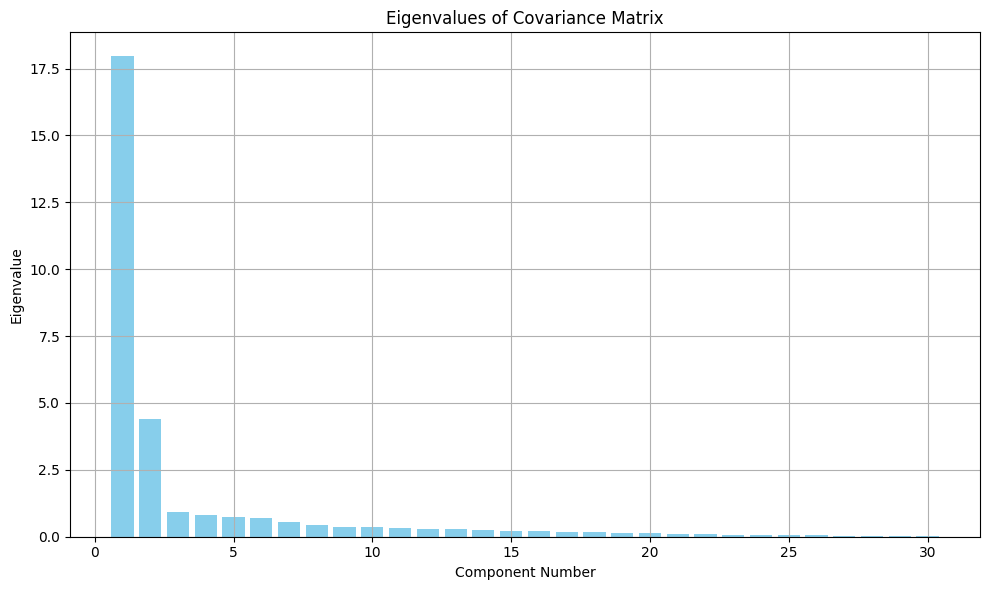

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(eigenvalues) + 1), eigenvalues, color='skyblue')
plt.title('Eigenvalues of Covariance Matrix')
plt.xlabel('Component Number')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.tight_layout()
plt.show()


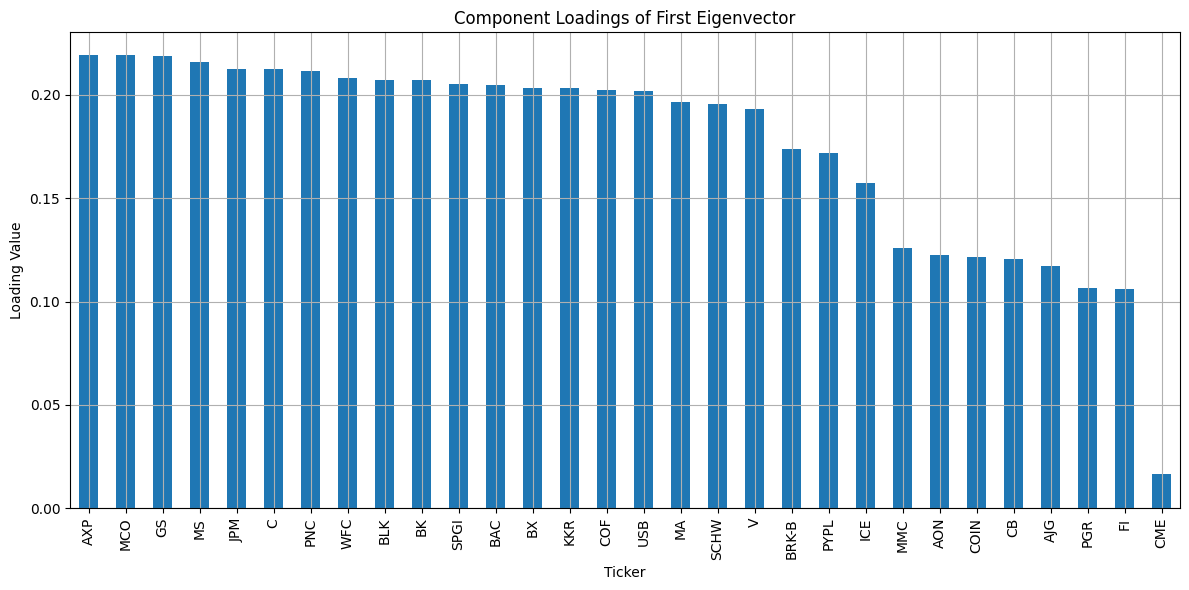

In [ ]:
#Plot of top contributing tickers
first_pc = eigenvectors[:, 0]
eigenvector_df = pd.DataFrame({'Ticker': price_returns.columns, 'First_PC_Loading': first_pc}).sort_values(by='First_PC_Loading', ascending=False)


eigenvector_df.set_index('Ticker').plot(kind='bar', figsize=(12, 6), legend=False)
plt.title('Component Loadings of First Eigenvector')
plt.ylabel('Loading Value')
plt.grid(True)
plt.tight_layout()
plt.show()